<a href="https://colab.research.google.com/github/jrw99/Deep-Learning/blob/main/AlphabetSoupCharity_Optimzation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [61]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt

# mount drive so colab can read/write files
from google.colab import drive
drive.mount('/content/drive')

application_df = pd.read_csv("/content/drive/MyDrive/Homework/Deep-Learning/Resources/charity_data.csv")
application_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


<h3>What variable(s) are considered the target(s) for your model?</h3>

Although STATUS and SPECIAL_CONSIDERATIONS are binary like IS_SUCCESSFUL, the purpose is to predict whether applicants will be successfull if funded.

<ul>
    <li>IS_SUCCESSFUL</li>
</ul>

<h3>What variable(s) are considered the feature(s) for your model?</h3>
<ul>
    <li>APPLICATION_TYPE</li>
    <li>AFFILIATION</li>
    <li>CLASSIFICATION</li>
    <li>USE_CASE</li>
    <li>ORGANIZATION</li>
    <li>INCOME_AMT</li>
    <li>ASK_AMT</li>
    <li>STATUS</li>
    <li>SPECIAL_CONSIDERATIONS</li>
</ul>

In [62]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
print(application_df.shape)
application_df.drop(['EIN','NAME'], axis=1, inplace=True)
print(application_df.shape)

(34299, 12)
(34299, 10)


In [63]:
# Determine the number of unique values in each column.
'''
for col in application_df:
    print(application_df[col].unique())
'''
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [64]:
# Look at APPLICATION_TYPE value counts for binning
application_df.APPLICATION_TYPE.value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [65]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`

# Going with T10 @ 528 to be the cuttoff.  Next is T9 which is 156 and all others after are less so grouping them all...
# *** INCREASING THE NUMBER OF VALUES IN THE OTHER bin - CHANGING THIS TO CUTOFF AT 737 so that only values > 1000  are separated out to see how this affects things ***
application_types_to_replace = []

for app, cnt in application_df.APPLICATION_TYPE.value_counts().iteritems():
    if cnt < 528:
        application_types_to_replace.append(app)

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [66]:
# Look at CLASSIFICATION value counts for binning
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [67]:
# You may find it helpful to look at CLASSIFICATION value counts >1
application_df['CLASSIFICATION'].value_counts()[application_df['CLASSIFICATION'].value_counts()> 1]


C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

In [68]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`

# Going with c2100 @ 1883 to be the cuttoff.  Next is c7000 which is 777 and all others after are less so grouping them all...
classifications_to_replace = []

for cla, cnt in application_df.CLASSIFICATION.value_counts().iteritems():
    if cnt < 1883:
        classifications_to_replace.append(cla)

# Replace in dataframe
for cla in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cla,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [69]:
application_df.ASK_AMT.value_counts()

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [70]:
print(application_df['ASK_AMT'].min(), application_df['ASK_AMT'].max())

5000 8597806340


In [71]:
application_df['ASK_AMT'].value_counts()[application_df['ASK_AMT'].value_counts()> 2]

5000     25398
10478        3
15583        3
63981        3
6725         3
Name: ASK_AMT, dtype: int64

In [72]:
pd.cut(application_df.ASK_AMT, bins=[0, 5000, 50000, 500000, 5000000, 8597806340], labels=['5000','5000-50,000','50,000-500,000', '500,000-5,000,000', '> 5,000,000' ]).value_counts()

5000                 25398
50,000-500,000        3727
5000-50,000           2947
500,000-5,000,000     1590
> 5,000,000            637
Name: ASK_AMT, dtype: int64

In [73]:
# 5000 is the min amount found for a loan ask and is the overwhelming majority of applicants - resampling to even out the data set would be in order
# binning the ask amount into more consumable ranges, or drop it... with all the amounts other than 5000 being only a few per amount, ...tried dropping it and it didn't help

# application_df = application_df.drop(['ASK_AMT'], axis=1)

# binning it
application_df['ASK_AMT_BIN']=pd.cut(application_df.ASK_AMT, bins=[0, 5000, 50000, 500000, 5000000, 8597806340], labels=['5000','5000-50,000','50,000-500,000', '500,000-5M', '> 5M' ])
application_df = application_df.drop(['ASK_AMT'], axis=1)
application_df.head()



,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,IS_SUCCESSFUL,ASK_AMT_BIN
0,T10,Independent,C1000,ProductDev,Association,1,0,N,1,5000
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,1,"50,000-500,000"
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,0,5000
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,1,"5000-50,000"
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,1,"50,000-500,000"


In [74]:
application_df.dtypes


APPLICATION_TYPE            object
AFFILIATION                 object
CLASSIFICATION              object
USE_CASE                    object
ORGANIZATION                object
STATUS                       int64
INCOME_AMT                  object
SPECIAL_CONSIDERATIONS      object
IS_SUCCESSFUL                int64
ASK_AMT_BIN               category
dtype: object

In [75]:
application_df['INCOME_AMT'] = application_df['INCOME_AMT'].astype('object')
application_df['ASK_AMT_BIN'] = application_df['ASK_AMT_BIN'].astype('object')

In [76]:
catColumns = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
#catColumns = [c for c in application_df.columns if application_df[c].dtype in ['object', 'category']]
catColumns

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS',
 'ASK_AMT_BIN']

In [77]:
# Remove Special_considerations as it is binary so we will optimize with drop_first
catColumns.remove('SPECIAL_CONSIDERATIONS')
catColumns

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'ASK_AMT_BIN']

In [78]:
# Convert categorical data to numeric with `pd.get_dummies`
converted_df = pd.get_dummies(application_df, columns=catColumns)
converted_df = pd.get_dummies(converted_df, columns=['SPECIAL_CONSIDERATIONS'], drop_first=True)
converted_df = pd.get_dummies(converted_df, columns=['STATUS'], drop_first=True)
converted_df.head()

,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,"ASK_AMT_BIN_50,000-500,000","ASK_AMT_BIN_500,000-5M",ASK_AMT_BIN_5000,"ASK_AMT_BIN_5000-50,000",ASK_AMT_BIN_> 5M,SPECIAL_CONSIDERATIONS_Y,STATUS_1
0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [79]:
# Split our preprocessed data into our features and target arrays
X = converted_df.drop('IS_SUCCESSFUL', axis=1).values
y = converted_df['IS_SUCCESSFUL'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [80]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [81]:
# Create directory structure for attempts
os.makedirs("/content/drive/MyDrive/Homework/Deep-Learning/Attempts", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Homework/Deep-Learning/Attempts/1", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Homework/Deep-Learning/Attempts/2", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Homework/Deep-Learning/Attempts/3", exist_ok=True)

In [82]:
from pandas._libs.tslibs import period

# Define callback for model weights
def createCheckPointCallback(attempt):
  fpath =  f"/content/drive/MyDrive/Homework/Deep-Learning/Attempts/{attempt}/"
  fname = "model_weights_{epoch}.hdf5"
  return ModelCheckpoint(filepath=fpath+fname,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

## Compile, Train and Evaluate the Model

<h3>Optimization Attempts</h3>

Each Attempt lists the specific things done different in that attempt in a text cell prior to where the code for the attempt exists.

Changes made at the preprocessing level will affect all attempts. 

<h3>Preprocessing Changes Made Above:</h3>

APPLICATION TYPE - Tried increasing the number of items going to the 'Other' bin, where I decided since T3 value was so much higher than any other type, I put all other types together to try and create more of a balance and therefore reducing the number of features based on the application type after standardization to see what affect this has.  It reduced the accuracy in all attempts so returned to original reccomendation.

CLASSIFICATION - Same issue as with APPLICATION TYPE, since the C1000 classification was so much higher than all others, I opted to also group all others together as 'other' to better balance against the C1000.  Again, this had a negative affect on the Accuracy, so I returned to the original reccomendation.

ASK_AMT - Same issue as with CLASSIFICATION and APPLICATION TYPE - the min amt - 5000 , is overwhelming compaired to all others combined. Creating a new column to bin this via ranges and then dropping the ask_amt may be advantageous. It was!  

Updated the converted_df by using drop_first with get_dummies on the binary features for status and special_recommendations to further reduce potential noise.  

<h2>Attempt #1 for 75%</h2>

Seeing how it goes using the same settings I did in the starter_code notebook, but with the preprocessing changes in place where I tried to reduce the features via removing potential noise.

In [83]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = number_input_features  * 0.66
hidden_nodes_layer2 = number_input_features / 2
epochs=50

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30)                1410      
                                                                 
 dense_11 (Dense)            (None, 23)                713       
                                                                 
 dense_12 (Dense)            (None, 1)                 24        
                                                                 
Total params: 2,147
Trainable params: 2,147
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [85]:
# Train the model
checkPoint_callBack = createCheckPointCallback('1')
fit_model = nn.fit(X_train_scaled,y_train,epochs=epochs, callbacks=[checkPoint_callBack])

Epoch 1/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5781 - accuracy: 0.7136
Epoch 2/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5560 - accuracy: 0.7271
Epoch 3/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5518 - accuracy: 0.7289
Epoch 4/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5498 - accuracy: 0.7293
Epoch 5/50
794/804 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.7307
Epoch 5: saving model to /content/drive/MyDrive/Homework/Deep-Learning/Attempts/1/model_weights_5.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5482 - accuracy: 0.7310
Epoch 6/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7309
Epoch 7/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5456 - accuracy: 0.7316
Epoch 8/50
804/804 [==============================] - 2s 2ms/step - loss: 0.5449 - accuracy: 0.7326
Epoch 9/50
8

In [86]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

ar_loss = []
ar_loss.append(model_loss)

ar_acc = []
ar_acc.append(model_accuracy)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5560 - accuracy: 0.7266 - 416ms/epoch - 2ms/step
Loss: 0.5560083389282227, Accuracy: 0.7266472578048706


In [87]:
# Export our model to HDF5 file
nn.save('/content/drive/MyDrive/Homework/Deep-Learning/Attempts/1/AlphabetSoupCharity.h5')

<h2>Attempt #2 for 75%</h2>


*   Increased # of nodes for layer 1 and layer 2
*   Increased # of epochs



In [88]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = number_input_features  * 2
hidden_nodes_layer2 = number_input_features - 13
epochs=100

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 92)                4324      
                                                                 
 dense_14 (Dense)            (None, 33)                3069      
                                                                 
 dense_15 (Dense)            (None, 1)                 34        
                                                                 
Total params: 7,427
Trainable params: 7,427
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [90]:
# Train the model
createCheckPointCallback('2')
fit_model = nn.fit(X_train_scaled,y_train,epochs=epochs, callbacks=[checkPoint_callBack])

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5692 - accuracy: 0.7183
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5546 - accuracy: 0.7291
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7296
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5483 - accuracy: 0.7322
Epoch 5/100
794/804 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7316
Epoch 5: saving model to /content/drive/MyDrive/Homework/Deep-Learning/Attempts/1/model_weights_5.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7322
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5457 - accuracy: 0.7328
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5452 - accuracy: 0.7331
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5441 - accuracy: 0.7339
Epoc

In [91]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

ar_loss.append(model_loss)

ar_acc.append(model_accuracy)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5770 - accuracy: 0.7263 - 426ms/epoch - 2ms/step
Loss: 0.5770400166511536, Accuracy: 0.7262973785400391


In [92]:
# Export our model to HDF5 file
nn.save('/content/drive/MyDrive/Homework/Deep-Learning/Attempts/2/AlphabetSoupCharity.h5')

<h2>Attempt #3 for 75%</h3>


* Adding 3rd layer with tanh activation function
* Evened out the number of units 




In [93]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = number_input_features  * 2 - 6 #(43 * 2 - 6 = 80)
hidden_nodes_layer2 = number_input_features - 3 #(43 - 3 = 40)
hidden_nodes_layer3 = number_input_features - 3 #(43 - 3 = 40)
epochs=100

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 86)                4042      
                                                                 
 dense_17 (Dense)            (None, 43)                3741      
                                                                 
 dense_18 (Dense)            (None, 43)                1892      
                                                                 
 dense_19 (Dense)            (None, 1)                 44        
                                                                 
Total params: 9,719
Trainable params: 9,719
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [95]:
# Train the model
createCheckPointCallback('3')
fit_model = nn.fit(X_train_scaled,y_train,epochs=epochs, callbacks=[checkPoint_callBack])

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5677 - accuracy: 0.7184
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5541 - accuracy: 0.7293
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7315
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5482 - accuracy: 0.7329
Epoch 5/100
792/804 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7324
Epoch 5: saving model to /content/drive/MyDrive/Homework/Deep-Learning/Attempts/1/model_weights_5.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7323
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5460 - accuracy: 0.7331
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5450 - accuracy: 0.7338
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5441 - accuracy: 0.7344
Epoc

In [96]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

ar_loss.append(model_loss)

ar_acc.append(model_accuracy)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5736 - accuracy: 0.7269 - 434ms/epoch - 2ms/step
Loss: 0.5736247301101685, Accuracy: 0.7268804907798767


In [97]:
d = {'Loss': ar_loss, 'Accuracy': ar_acc}
df_Results = pd.DataFrame(d)
df_Results.dtypes

df_Results["Loss"] = df_Results["Loss"].astype("str").astype("float")
df_Results["Accuracy"] = df_Results["Accuracy"].astype("str").astype("float")
df_Results.dtypes

df_Results

,Loss,Accuracy
0,0.556008,0.726647
1,0.577040,0.726297
2,0.573625,0.726880


In [98]:
# Export our model to HDF5 file
nn.save('/content/drive/MyDrive/Homework/Deep-Learning/Attempts/3/AlphabetSoupCharity.h5')

<h1>Report on Outcome</h1>

<h2>Overview</h2>

The purpose of this analysis is to be able to answer the question: Will this applicant be succsessful in utiziation of funds, if funded by Alphabet Soup?  Given this is a yes/no answer (if you are not successfull, then you are unsuccessfull), it's binary. Therefore we are looking at a binary classifer, capable of making predictions on the success of a given applicants use of funds.


<h2>Results</h2>

<h3>Data Preprocessing</h3>

<i>What variable(s) are considered the target(s) for your model?</i>

Since the question is directly about the successfull use of funds, and we have a single binary field denoting this - IS_SUCCESFUL, we make this is our target.

<i>What variable(s) are considered to be the features for your model?</i>

All other variables are considered to be features until they are scrutinized and then deemed to be either:
* a feature as is
* a feature in need of preprocessing
* not a useful predictor for the question to be answered and potentially a detractor model accuracy.

This is the feature list... 

<ul>
    <li>APPLICATION_TYPE</li>
    <li>AFFILIATION</li>
    <li>CLASSIFICATION</li>
    <li>USE_CASE</li>
    <li>ORGANIZATION</li>
    <li>INCOME_AMT</li>
    <li>ASK_AMT</li>
    <li>STATUS</li>
    <li>SPECIAL_CONSIDERATIONS</li>
</ul>

...but further scrutiny was required:

* APPLICATION TYPE - Tried increasing the number of items going to the 'Other' bin, where I decided since T3 value was so much higher than any other type, I put all other types together to try and create more of a balance and therefore reducing the number of features based on the application type after standardization to see what affect this has.  It reduced the accuracy in all attempts so returned to original reccomendation.

* CLASSIFICATION - Same issue as with APPLICATION TYPE, since the C1000 classification was so much higher than all others, I opted to also group all others together as 'other' to better balance against the C1000.  Again, this had a negative affect on the Accuracy, so I returned to the original reccomendation.

* ASK_AMT - Same issue as with CLASSIFICATION and APPLICATION TYPE - the min amt - 5000 , is overwhelming compaired to all others combined. Creating a new column to bin this via ranges and then dropping the ask_amt may be advantageous. It was!  

* While using get_dummies, dropped redundant binary features for STATUS_0 and SPECIAL_CONSIDERATIONS_N using the drop_first option to further reduce potential noise.

<i>What variable(s) are neither targets nor features, and should be removed from the input data?</i>

The EIN and Name fields are both unique to each row, and have no bearing on the outcome because no meaningful correlation to other applicants can be made with this information and were removed as per the initial instructions.

Furthermore, as outlined above, binary fields that were split (STATUS and SPECIAL_CONSIDERATIONS) could have their secondary fields removed and this was done.

<h3>Compiling, Training, and Evaluating the Model</h3>

<i>How many neurons, layers, and activation functions did you select for your neural network model, and why?</i>

On my first attempt, I went with the same setup I used in the starter code notebook, to see what the difference was after my preprocessing changes. Oddly enough, my results were slight worse, going from 55.5%, Accuracy: 72.7% to 55.6% loss and	72.6%.

For my second attempt, I:

* increased # of nodes for layer 1 and layer 2
* increased # of epochs

And for my third attempt, I:

* added a 3rd layer with the tanh activation function
* evened out the number of units

<i>Were you able to achieve the target model performance?</i>

* No, I acheived a maximum of accuracy of 72.68%, in my third attempt

<i>What steps did you take to try and increase model performance?</i>

* Addressed throughout the entire explantion above.

<h2>Summary</h2>

Overall, although an increase in accuracy was acheived via my third and final attempt, (see plot below) I did not hit the target of 75% accuracy.

Even after further preprocessing features on an individual level, the balance of the dataset as a whole is in question and requires some form of balancing beyond standardization.  Given the dataset is unbalanced (the values in the application type, classification and ask_amnt variables) rebalancing and then running the existing model(s) could be done and then if the desired result is still not met, then exploring other model implementations would be warranted.



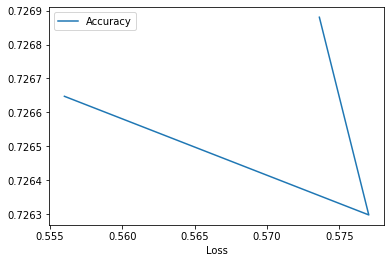

In [99]:
df_Results.plot(x = 'Loss', y ='Accuracy')   
plt.show()        
